In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
DATA_DIR = "/content/drive/My Drive/chest_xray/chest_xray/"
dir_callbacks = "/content/drive/My Drive/MobileNet/"
os.listdir(DATA_DIR)

['test', 'train']

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import files
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import itertools
from tensorflow.keras import optimizers

In [5]:
LEARNING_RATE =1E-4

In [6]:
def Model_MobileNet():
      base_model=MobileNet( include_top=False,	input_tensor=Input(shape=(400, 400, 3)),alpha=0.75) #imports the mobilenet model and discards the last 1000 neuron layer.
      #base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
      base_model.load_weights("/content/drive/My Drive/MobileNet/mobilenet_7_5_224_tf_no_top.h5")
      for layer in base_model.layers:
	        layer.trainable = False
      
      x=base_model.output
      x=GlobalAveragePooling2D()(x)
      x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
      x=Dense(1024,activation='relu')(x) #dense layer 2
      x=Dense(512,activation='relu')(x) #dense layer 3
      preds=Dense(2,activation='softmax')(x) #final layer with softmax activation


      model=Model(inputs=base_model.input,outputs=preds)
      # for layer in model.layers[:20]:
      #     layer.trainable=False
      # for layer in model.layers[20:]:
      #     layer.trainable=True


      model.compile(optimizer=optimizers.Adam(lr=LEARNING_RATE),loss='categorical_crossentropy',metrics=['accuracy'])
      model.summary()

      return model

In [7]:
Model_MobileNet = Model_MobileNet()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 401, 401, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 200, 200, 24)      648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 200, 200, 24)      96        
_________________________________________________________________
conv1_relu (ReLU)            (None, 200, 200, 24)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 200, 200, 24)      216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 200, 200, 24)      96    

In [8]:
# base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(1024,activation='relu')(x) #dense layer 2
# x=Dense(512,activation='relu')(x) #dense layer 3
# preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [9]:
train_path =DATA_DIR + "train"
test_path = DATA_DIR + "test"

In [10]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(train_path,
                                                  target_size=(400,400),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', shuffle=True)

Found 5216 images belonging to 2 classes.


In [11]:
valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator=valid_datagen.flow_from_directory(test_path,
                                                  target_size=(400,400),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', shuffle=False)

Found 624 images belonging to 2 classes.


In [12]:
import pandas as pd
import math

df = pd.DataFrame({'data':train_generator.classes})
no_pne = int(df[df.data==train_generator.class_indices['NORMAL']].count())
yes_pne = int(df[df.data==train_generator.class_indices['PNEUMONIA']].count())

imb_rat = round(yes_pne / no_pne, 2)

no_weight = imb_rat
yes_weight = 1.0

cweights = {
 train_generator.class_indices['NORMAL']:no_weight,
 train_generator.class_indices['PNEUMONIA']:yes_weight
}

text = "Normal:{:.0f}\nPneumonia:{:.0f}\nImbalance Ratio: {:.2f}\n".format(no_pne, yes_pne, imb_rat)
print(text)
text = "Using class_weights as:\nNormal:{:.2f}\nPneumonia:{:.2f}\n".format(no_weight, yes_weight)
print(text)

Normal:1341
Pneumonia:3875
Imbalance Ratio: 2.89

Using class_weights as:
Normal:2.89
Pneumonia:1.00



In [13]:
batch_size = 32
epochs =10


from tensorflow.keras.models import load_model
checkpoint = ModelCheckpoint(filepath=dir_callbacks + 'best_weights_mobile_net.h5', save_best_only=True)


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

if (os.path.exists(dir_callbacks + 'best_weights_mobile_net.h5')):
      Model_MobileNet= tensorflow.keras.models.load_model(dir_callbacks + 'best_weights_mobile_net.h5')

In [14]:
hist = Model_MobileNet.fit_generator(
           train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=valid_generator, 
           validation_steps=valid_generator.samples // batch_size,
           callbacks=[checkpoint, lr_reduce],
           class_weight=cweights)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 [==============================] - 2459s 15s/step - loss: 0.2659 - accuracy: 0.9270 - val_loss: 0.4520 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 2/10
163/163 [==============================] - 84s 518ms/step - loss: 0.1282 - accuracy: 0.9661 - val_loss: 0.4760 - val_accuracy: 0.8372 - lr: 1.0000e-04
Epoch 3/10
163/163 [==============================] - 84s 517ms/step - loss: 0.0904 - accuracy: 0.9760 - val_loss: 0.5259 - val_accuracy: 0.8388 - lr: 1.0000e-04
Epoch 4/10
163/163 [==============================] - 84s 513ms/step - loss: 0.0766 - accuracy: 0.9804 - val_loss: 0.5597 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 5/10
163/163 [==============================] - 84s 517ms/step - loss: 0.0719 - accuracy: 0.9781 - val_loss: 0.8479 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/10
163/163 [==============================] - 84s 514ms/step - loss: 0.0476 - accuracy: 0.9866 - val_loss:

In [15]:
hist = Model_MobileNet.fit_generator(
           train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=valid_generator, 
           validation_steps=valid_generator.samples // batch_size,
           callbacks=[checkpoint, lr_reduce],
           class_weight=cweights)

Epoch 1/10
163/163 [==============================] - 84s 516ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.6888 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 2/10
163/163 [==============================] - 85s 521ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 1.6260 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/10
163/163 [==============================] - 85s 519ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.6793 - val_accuracy: 0.8651 - lr: 1.0000e-04
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9954
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 [==============================] - 84s 517ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 1.4827 - val_accuracy: 0.7796 - lr: 1.0000e-04
Epoch 5/10
163/163 [==============================] - 84s 514ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 1.4331 - val_accuracy: 0.7845 - lr: 3.0000e-05
Epoch 6/10
163/163 [====

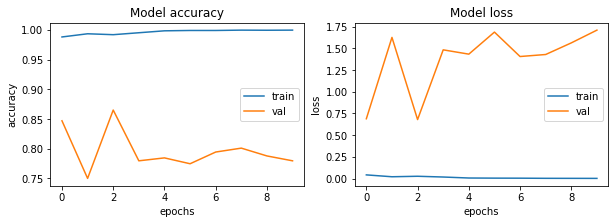

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
pd.DataFrame(hist.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.042035,0.988305,0.688823,0.847039,0.000100
1,0.020489,0.993673,1.625979,0.750000,0.000100
2,0.026135,0.992140,0.679290,0.865132,0.000100
3,0.017421,0.995399,1.482741,0.779605,0.000100
4,0.006019,0.998658,1.433138,0.784539,0.000030
5,0.004555,0.999233,1.687139,0.774671,0.000030
6,0.004005,0.999233,1.405759,0.794408,0.000030
7,0.002461,0.999808,1.429083,0.800987,0.000030
8,0.002063,0.999617,1.562912,0.787829,0.000009
9,0.001671,0.999808,1.709826,0.779605,0.000009


In [19]:
#test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path , target_size = (224,224) , classes =['NORMAL','PNEUMONIA'] , batch_size=624)
valid_generator=valid_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=624,
                                                  class_mode='categorical', shuffle=False)
X_test , y_test = next(valid_generator)

Found 624 images belonging to 2 classes.


In [20]:
Model_MobileNet= tensorflow.keras.models.load_model(dir_callbacks + 'best_weights_mobile_net.h5')

In [21]:
y_pred = Model_MobileNet.predict(X_test, batch_size=624 ,verbose=1)
y_predicted = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 1ms/step


In [22]:
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis=1), y_predicted))

Confusion Matrix
[[127 107]
 [ 15 375]]


In [23]:
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(np.argmax(y_test, axis=1), y_predicted, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.89      0.54      0.68       234
   PNEUMONIA       0.78      0.96      0.86       390

    accuracy                           0.80       624
   macro avg       0.84      0.75      0.77       624
weighted avg       0.82      0.80      0.79       624



In [24]:
acc = accuracy_score(np.argmax(y_test, axis=1), np.round(y_predicted))*100
cm = confusion_matrix(np.argmax(y_test, axis=1), np.round(y_predicted))
tn, fp, fn, tp = cm.ravel()

In [25]:
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Accuracy: 80.44871794871796%
Precision: 77.80082987551867%
Recall: 96.15384615384616%
F1-score: 86.0091743119266


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

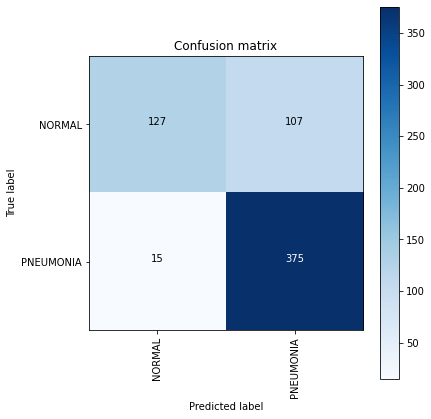

In [27]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_predicted), classes = ['NORMAL','PNEUMONIA'])

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
def Plot_Roc_Curve():    
    fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), y_predicted)
    fig, ax1 = plt.subplots(1,1, figsize = (2.5, 2.5), dpi = 200)
    ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(np.argmax(y_test, axis=1), y_predicted))
    ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    ax1.legend(loc = 4)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate');

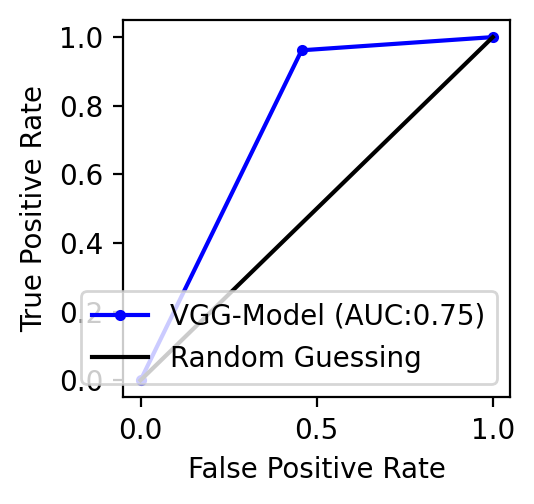

In [29]:
Plot_Roc_Curve()

In [30]:
from keras.models import load_model
new_model = tensorflow.keras.models.load_model(dir_callbacks + 'best_weights_mobile_net.h5')

def get_rez(pic):
  img = image.load_img(pic, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  p_good,p_ill = np.around(new_model.predict(x), decimals=2)[0]
  return{'p_good':p_good,'p_ill':p_ill}

Using TensorFlow backend.


In [31]:
ill_path =  train_path + "/PNEUMONIA/" 
good_path = train_path + "/NORMAL/" 

ill_pic = ill_path + os.listdir(ill_path)[0]
good_pic = good_path + os.listdir(good_path)[0]

print(get_rez(ill_pic))
print(get_rez(good_pic))

{'p_good': 0.01, 'p_ill': 0.99}
{'p_good': 0.88, 'p_ill': 0.12}
